In [155]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple
from pathlib import Path

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)

# Custom imports
from GEMS_TCO import data_map_by_hour 

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings
from GEMS_TCO import load_data
from GEMS_TCO import configuration as config
import pickle


# past data investigation

In [154]:
lat_lon_resolution = [2,2]
years = ['2024']
month_range =[7,8]
nheads = 2
mm_cond_number = 10 

day = 9
idx_for_datamap= [ 8*(day-1),8*day]
data_load_instance = load_data(config.mac_data_load_path)
df = data_load_instance.read_pickle(config.mac_estimates_day_path,config.mac_full_day_v05_pickle)
map, ord_mm, nns_map= data_load_instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
analysis_data_map, aggregated_data = data_load_instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

keys = list(analysis_data_map.keys())
hour = 1 
print(analysis_data_map[keys[hour-1]].shape)  #4595/5000  13180/20000
print(pd.Series(analysis_data_map[keys[hour-1]][:,2]).nunique())

torch.Size([5000, 4])
4611


In [ ]:
output_filepath = '/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl'

with open(output_filepath, 'rb') as pickle_file:
    data_map_hour = pickle.load(pickle_file)

In [175]:
class center_matching_hour():
    """
    Processes orbit data by averaging over specified spatial regions and resolutions.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        lat_s (int): Start latitude for spatial averaging.
        lat_e (int): End latitude for spatial averaging.
        lon_s (int): Start longitude for spatial averaging.
        lon_e (int): End longitude for spatial averaging.
        lat_resolution (Optional[float]): Latitude resolution for spatial bins. Default is None.
        lon_resolution (Optional[float]): Longitude resolution for spatial bins. Default is None.
    """
    def __init__(
        self, 
        df:pd.DataFrame=None, 
        lat_s:float =5,
        lat_e:float =10, 
        lon_s:float =110,
        lon_e:float =120, 
        lat_resolution:float=None, 
        lon_resolution:float =None
    ):
        # Input validation
        if df is not None:
            assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame"

        if lat_resolution is not None:
            assert isinstance(lat_resolution, float), "lat_resolution must be a float"
        if lon_resolution is not None:
            assert isinstance(lon_resolution, float), "lon_resolution must be a float"
        
        self.df = df
        self.lat_resolution = lat_resolution
        self.lon_resolution = lon_resolution
        self.lat_s = lat_s
        self.lat_e = lat_e
        self.lon_s = lon_s
        self.lon_e = lon_e

    def group_data_by_orbits(self):
        """
        Groups data into a dictionary based on unique orbit timestamps.

        Returns:
            dict: A dictionary where keys represent formatted orbit identifiers 
                and values are DataFrames corresponding to each orbit.
        """
        orbit_map = {}  
        self.df['Orbit'] = self.df['Time'].str[0:16]
        orbits = self.df['Orbit'].unique()
        for orbit in orbits:
            orbit_key = f'y{orbit[2:4]}m{int(orbit[5:7]):02d}day{ int(orbit[8:10]):02d}_hm{(orbit[11:16])}'
            orbit_map[orbit_key] = self.df.loc[self.df['Orbit'] == orbit].reset_index(drop=True)
        return orbit_map
    


    def make_center_points(self, step_lat:float=0.022, step_lon:float=0.063) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e,self.lat_s, -step_lat)
        lon_coords = np.arange( self.lon_e,self.lon_s, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat
        final_lon_values = lon_coords + step_lon
        
        # Create the grid using vectorized operations
        # This matches the order of the original nested loops (outer lat, inner lon)
        center_lats = np.repeat(final_lat_values, len(final_lon_values))
        center_lons = np.tile(final_lon_values, len(final_lat_values))
        
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})
        return center_points_df


    def coarse_by_center(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        # Convert query points (lat, lon) to NumPy array
        query_points = center_points[['lat', 'lon']].to_numpy()
        query_points_rad = np.radians(query_points)  # if using haversine

        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # Use haversine
            locs_rad = np.radians(locs)
            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            nearest_indices = ind.flatten()

            # Extract values from the nearest source points
            res_o3_values = cur_data.loc[nearest_indices, 'ColumnAmountO3'].values
            source_lat = cur_data.loc[nearest_indices, 'Latitude'].values
            source_lon = cur_data.loc[nearest_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': center_points['lat'].values,
                'Longitude': center_points['lon'].values,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * num_center_points,
                'Time': [time_val] * num_center_points,
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map


    def coarse_by_center3(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        query_points = center_points[['lat', 'lon']].to_numpy()
        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # tree = BallTree(locs, metric='euclidean')
            # dist, ind = tree.query(query_points, k=1)

            locs_rad = np.radians(locs)
            query_points_rad = np.radians(query_points)

            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            # Optionally convert to meters (if you care about the actual distance)
            dist_meters = dist * 6371000  # Earth's radius in meters


            nearest_indices = ind.flatten()

            # Deduplicate: keep only the first match per source point
            _, unique_query_indices = np.unique(nearest_indices, return_index=True)
            unique_query_indices = np.sort(unique_query_indices)

            filtered_indices = nearest_indices[unique_query_indices]
            filtered_lat = center_points['lat'].iloc[unique_query_indices].values
            filtered_lon = center_points['lon'].iloc[unique_query_indices].values
            res_o3_values = cur_data.loc[filtered_indices, 'ColumnAmountO3'].values

            source_lat = cur_data.loc[filtered_indices, 'Latitude'].values
            source_lon = cur_data.loc[filtered_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': filtered_lat,
                'Longitude': filtered_lon,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * len(filtered_lat),
                'Time': [time_val] * len(filtered_lat),
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map



In [160]:
base_path = config.mac_data_load_path
output_path = base_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
# lat_start, lat_end, lon_start, lon_end = 9.0, 9.003, 113.45, 123.55

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC
instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)  


### Experiment regular grids

In [ ]:
step_lat_list = [0.022]
step_lon_list = [0.066]
lon_start_list = [123.0]
for lon_start in lon_start_list:
    instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)   
    for step_lat in step_lat_list:
        for step_lon in step_lon_list:
            center_points = instance.make_center_points(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(data_map_hour, center_points)
  
            coarse_cen_map3 = instance.coarse_by_center3(data_map_hour, center_points)
            res = []
            keys_list = list(coarse_cen_map.keys())
            for key in keys_list:
                res.append( coarse_cen_map[key]['ColumnAmountO3'].nunique()/ data_map_hour[key].shape[0]*100)
            
            res = np.array(res)
            print(f' step_lat: {step_lat}, step_lon: {step_lon}, averaged nunqiue is {np.mean(res)}')


 step_lat: 0.022, step_lon: 0.066, averaged nunqiue is 89.64913472580034


In [189]:
coarse_cen_map['y24m07day01_hm00:52']

,Latitude,Longitude,ColumnAmountO3,Hours_elapsed,Time,Source_Latitude,Source_Longitude
0,5.022,133.066,260.68182,477720.866667,2024-07-01 00:52:00,4.998375,132.984420
1,5.022,133.000,260.68182,477720.866667,2024-07-01 00:52:00,4.998375,132.984420
2,5.022,132.934,262.34076,477720.866667,2024-07-01 00:52:00,4.998421,132.920550
3,5.022,132.868,262.01970,477720.866667,2024-07-01 00:52:00,4.998329,132.858930
4,5.022,132.802,264.06370,477720.866667,2024-07-01 00:52:00,4.998335,132.795360
...,...,...,...,...,...,...,...
34651,0.028,123.364,258.65015,477720.866667,2024-07-01 00:52:00,0.019090,123.382620
34652,0.028,123.298,255.71344,477720.866667,2024-07-01 00:52:00,0.019237,123.320625
34653,0.028,123.232,256.08010,477720.866667,2024-07-01 00:52:00,0.019475,123.257930
34654,0.028,123.166,254.48645,477720.866667,2024-07-01 00:52:00,0.019675,123.195335


In [177]:
keys = list(coarse_cen_map3.keys())
for key in keys:
    print(coarse_cen_map3[key].shape, coarse_cen_map3[key]['ColumnAmountO3'].nunique() )

(33040, 7) 32054
(30619, 7) 29877
(29760, 7) 29042
(29158, 7) 28449
(24833, 7) 24296
(27603, 7) 26816
(28679, 7) 27755
(28689, 7) 27632
(32989, 7) 32034
(32331, 7) 31528
(32326, 7) 31475
(32173, 7) 31452
(27830, 7) 27245
(28598, 7) 27958
(28676, 7) 27892
(28680, 7) 27815
(32130, 7) 31248
(30957, 7) 30261
(30668, 7) 30055
(30974, 7) 30339
(26624, 7) 26137
(27525, 7) 26951
(28697, 7) 28029
(28685, 7) 27967
(32977, 7) 32088
(31421, 7) 30578
(31110, 7) 30394
(31147, 7) 30495
(26914, 7) 26391
(27595, 7) 27084
(28694, 7) 28052
(28696, 7) 27962
(32658, 7) 31683
(31894, 7) 31099
(31819, 7) 31059
(31934, 7) 31097
(27968, 7) 27242
(28513, 7) 27870
(28672, 7) 27912
(28674, 7) 27822
(32793, 7) 31525
(32588, 7) 31525
(32413, 7) 31386
(32384, 7) 31391
(27944, 7) 27178
(28210, 7) 27367
(28704, 7) 27654
(28673, 7) 27521
(32867, 7) 31965
(32233, 7) 31455
(32333, 7) 31531
(32412, 7) 31583
(28153, 7) 27551
(28533, 7) 27948
(28723, 7) 28166
(28684, 7) 27951
(32908, 7) 31931
(28971, 7) 28345
(28826, 7) 281

In [116]:
coarse_cen_map3['y23m07day01_hm01:59'][550:600]

,Latitude,Longitude,ColumnAmountO3,Hours_elapsed,Time,Source_Latitude,Source_Longitude
550,10.034,114.935,265.72235,468937.983333,2023-07-01 01:59:00,10.031492,114.936356
551,10.034,114.870,269.42426,468937.983333,2023-07-01 01:59:00,10.032108,114.870300
552,10.034,114.805,268.66614,468937.983333,2023-07-01 01:59:00,10.032625,114.804190
553,10.034,114.740,269.84378,468937.983333,2023-07-01 01:59:00,10.033289,114.737870
554,10.034,114.675,269.54285,468937.983333,2023-07-01 01:59:00,10.033915,114.671860
555,10.034,114.610,269.77557,468937.983333,2023-07-01 01:59:00,10.034577,114.605690
556,10.034,114.545,265.19067,468937.983333,2023-07-01 01:59:00,10.035058,114.539390
557,10.034,114.480,267.13712,468937.983333,2023-07-01 01:59:00,10.035669,114.473236
558,10.034,114.415,267.87714,468937.983333,2023-07-01 01:59:00,10.036350,114.406770
559,10.034,114.350,267.45166,468937.983333,2023-07-01 01:59:00,10.036940,114.340650


In [51]:
a = coarse_cen_map['y23m07day01_hm00:59'][['Latitude','Longitude','ColumnAmountO3']]
b = data_map_hour['y23m07day01_hm00:59'][['Latitude','Longitude','ColumnAmountO3']]
c = coarse_cen_map2['y23m07day01_hm00:59'][['Latitude','Longitude','ColumnAmountO3']]
d = coarse_cen_map3['y23m07day01_hm00:59'][['Latitude','Longitude','ColumnAmountO3']]

In [ ]:
pd.concat( (a,  b), axis=1)

In [266]:
step_lat_list = [0.022, 0.03, 0.05, 0.1]
step_lon_list = [0.05, 0.066, 0.067 , 0.069]

for step_lat in step_lat_list:
    for step_lon in step_lon_list:
        center_points = instance.make_center_points(step_lat = step_lat, step_lon= step_lon)
        coarse_cen_map = instance.coarse_by_center(data_map_hour, center_points)
        res = []
        keys_list = list(coarse_cen_map.keys())
        for key in keys_list:
            res.append( coarse_cen_map[key]['ColumnAmountO3'].nunique()/ data_map_hour[key].shape[0]*100 )
        
        res = np.array(res)
        print(f' step_lat: {step_lat}, step_lon: {step_lon}, averaged nunqiue is {np.mean(res)}')


 step_lat: 0.022, step_lon: 0.05, averaged nunqiue is 74.20919203689267
 step_lat: 0.022, step_lon: 0.066, averaged nunqiue is 72.29972810720955
 step_lat: 0.022, step_lon: 0.067, averaged nunqiue is 71.29767952482906
 step_lat: 0.022, step_lon: 0.069, averaged nunqiue is 69.36169186395566
 step_lat: 0.03, step_lon: 0.05, averaged nunqiue is 56.18861509673871
 step_lat: 0.03, step_lon: 0.066, averaged nunqiue is 54.10149619324999
 step_lat: 0.03, step_lon: 0.067, averaged nunqiue is 53.34813419340462
 step_lat: 0.03, step_lon: 0.069, averaged nunqiue is 51.88590953643159
 step_lat: 0.05, step_lon: 0.05, averaged nunqiue is 34.522073100401016
 step_lat: 0.05, step_lon: 0.066, averaged nunqiue is 33.214199146311024
 step_lat: 0.05, step_lon: 0.067, averaged nunqiue is 32.75070796767658
 step_lat: 0.05, step_lon: 0.069, averaged nunqiue is 31.847915714646454
 step_lat: 0.1, step_lon: 0.05, averaged nunqiue is 17.635706577508838
 step_lat: 0.1, step_lon: 0.066, averaged nunqiue is 16.95483

In [255]:
center_points = instance.make_center_points(step_lat = 0.03, step_lon= 0.069)
coarse_cen_map = instance.coarse_by_center(data_map_hour, center_points)
coarse_cen_map['y23m07day01_hm00:59']['ColumnAmountO3'].nunique()

32723

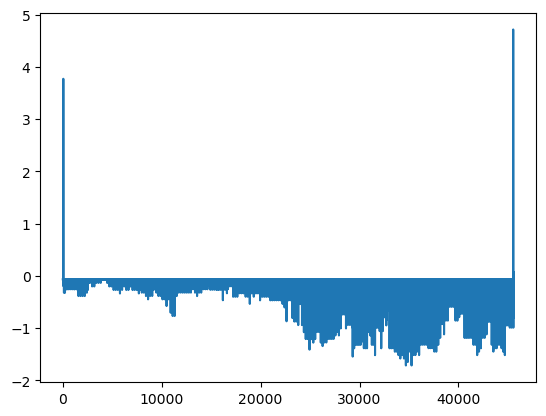

In [208]:
a = data_map_hour['y24m07day01_hm00:59']['Longitude']-data_map_hour['y24m07day01_hm00:59']['Longitude'].shift()
a = a[ abs(a)<5]
plt.plot(a[1:])

In [218]:
a[abs(a)>0.0015]

58      -0.043
161     -0.066
225      0.002
304     -0.088
359      0.002
482     -0.110
691     -0.131
746      0.002
891      0.002
901     -0.132
956      0.002
1113    -0.132
1167     0.002
1325    -0.132
1378     0.002
1538    -0.131
1589     0.002
1750    -0.131
1801     0.003
1912     0.002
1961    -0.131
2012     0.003
2172    -0.131
2223     0.002
2384    -0.130
2435     0.002
2546     0.003
2593    -0.130
2807    -0.129
2971     0.002
3022    -0.130
3187     0.002
3237    -0.130
3403     0.002
3453    -0.129
3618     0.002
3669    -0.129
3885    -0.128
4102    -0.129
4319    -0.128
4535    -0.128
4714     0.002
4750    -0.128
4929     0.002
4965    -0.127
5144     0.003
5179    -0.127
5358     0.003
5393    -0.127
5557     0.002
5572     0.003
5607    -0.127
5785     0.003
5820    -0.127
5998     0.003
6034    -0.126
6212     0.002
6249    -0.126
6426     0.002
6463    -0.125
6640     0.002
6665     0.002
6676    -0.126
6852     0.002
6889    -0.126
7063     0.002
7100    -0

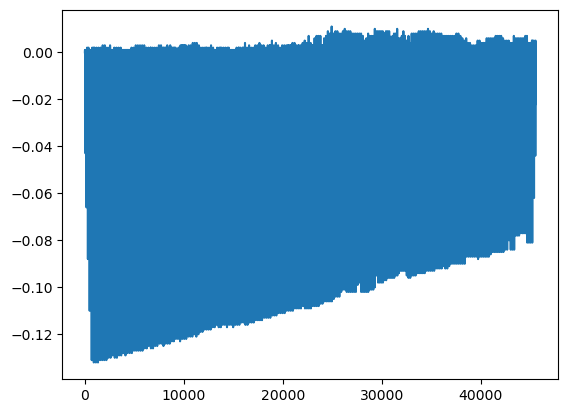

In [216]:

a = data_map_hour['y24m07day01_hm00:59']['Latitude']-data_map_hour['y24m07day01_hm00:59']['Latitude'].shift()

plt.plot(a)

In [193]:
print(coarse_cen_map['y24m07day01_hm00:59']['ColumnAmountO3'].shape)
coarse_cen_map['y24m07day01_hm00:59']['ColumnAmountO3'].nunique()

(202,)


155

In [ ]:
pd.set_option('display.max_rows', None)

coarse_cen_map['y24m07day01_hm00:59']  
# 5-6: 5915, 4882
# 6-7: 5915, 4825
# 7-8: 5746, 5216
# 8-9:  5149
# 9-10: 5212

In [242]:
coarse_cen_map['y24m07day01_hm00:59']['ColumnAmountO3'].nunique()

KeyError: 'y24m07day01_hm00:59'